<img src="../assets/ga-logo.png" style="float: left; margin: 20px; height: 55px">

# Cross-Validation Lesson

_Authors: Dave Yerrington (SF), Joseph Nelson (DC), Kiefer Katovich (SF), Riley Dallas(AUS), Adi Bronshtein (Live Online)_

---

### Learning Objectives
- **Describe** train/test split and cross-validation.
- **Explain** how these validation techniques differ and why we want to use them.
- **Split** data into testing and training sets using both train/test split and cross-validation and **apply** both techniques to score a model.

## Overfitting and Underfitting

---

# **STRAIGHT LINE IS BIASED. Too Simple**

![](../assets/overfitting.jpg)


**What's wrong with the first model?**
- The underfit model falls short of capturing the complexity of the "true model" of the data.

**What's wrong with the third model?**
- The overfit model is too complex and is modeling random noise in the data.

**The middle model is a good compromise.**
- It approximates the complexity of the true model and does not model random noise in our sample as true relationships.

![](../assets/overfitting2.png)

## Importing libraries

---

We'll need the following libraries for today's lesson:
- `pandas`
- `numpy`
- `seaborn`
- we'll need a `LinearRegression` from `sklearn.linear_model`
- from `sklearn.model_selection` we'll need `train_test_split`, and `cross_val_score`

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error

<a id='demo'></a>

## Load the Data

---

Today's [dataset](http://faculty.marshall.usc.edu/gareth-james/ISL/data.html) (`Advertising.csv`) is from the [ISLR website](http://faculty.marshall.usc.edu/gareth-james/ISL/index.html). 

Drop `Unnamed: 0` once you've loaded the csv into a `DataFrame`.

In [8]:
ads = pd.read_csv('https://raw.githubusercontent.com/nguyen-toan/ISLR/master/dataset/Advertising.csv')

ads.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [9]:
ads.drop(columns = 'Unnamed: 0', inplace = True)

In [10]:
ads.head()

,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


## Data cleaning
---

Check the following in the cells below:
1. Do we have any null values?
2. Do we have all numerical columns?

In [11]:
# Check for nulls
ads.isnull().sum()

TV           0
Radio        0
Newspaper    0
Sales        0
dtype: int64

In [12]:
# Check column data types
ads.dtypes

TV           float64
Radio        float64
Newspaper    float64
Sales        float64
dtype: object

In [13]:
# Two for the price of one:
ads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   Radio      200 non-null    float64
 2   Newspaper  200 non-null    float64
 3   Sales      200 non-null    float64
dtypes: float64(4)
memory usage: 6.4 KB


## EDA: Plot a Heatmap of the Correlation Matrix
---

Heatmaps are an effective way to visually examine the correlational structure of your predictors. 

In [14]:
# Correlation matrix
ads.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


In [17]:
# Correlation with the target varialbe (sales) - data series
ads.corr()['Sales']

TV           0.782224
Radio        0.576223
Newspaper    0.228299
Sales        1.000000
Name: Sales, dtype: float64

In [18]:
# Correlation with the target varialbe (sales) - data frame
ads.corr()[['Sales']]

,Sales
TV,0.782224
Radio,0.576223
Newspaper,0.228299
Sales,1.000000


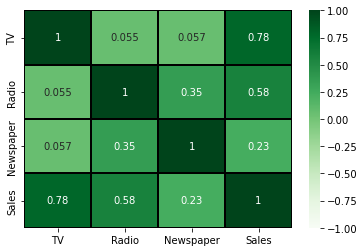

In [19]:
# Correlation heatmap
sns.heatmap(ads.corr(), cmap="Greens", vmin=-1, vmax=1, annot=True, linecolor="black",
           linewidths=2);

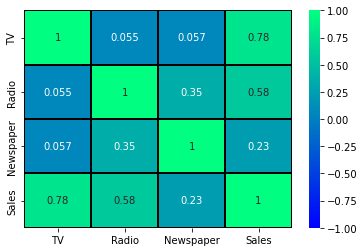

In [20]:
sns.heatmap(ads.corr(), cmap = 'winter',
           vmin = -1, vmax = 1, annot = True, linecolor = 'black',
           linewidths = 2);

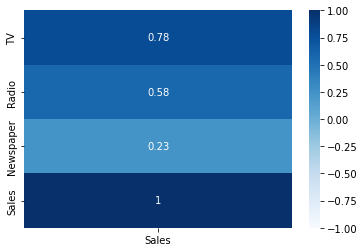

In [23]:
#  heatmap with features correlation with sales only
sns.heatmap(ads.corr()[['Sales']], cmap='Blues', annot=True, vmin=-1, vmax=1);

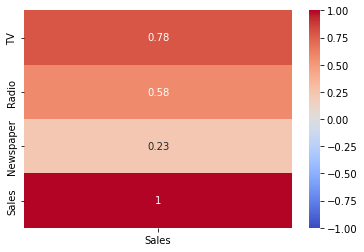

In [24]:
sns.heatmap(ads.corr()[['Sales']],
           cmap = 'coolwarm', annot = True,
           vmin = -1, vmax = 1);

## EDA: Use seaborn's `.pairplot()` method to create scatterplots for each of our columns
---

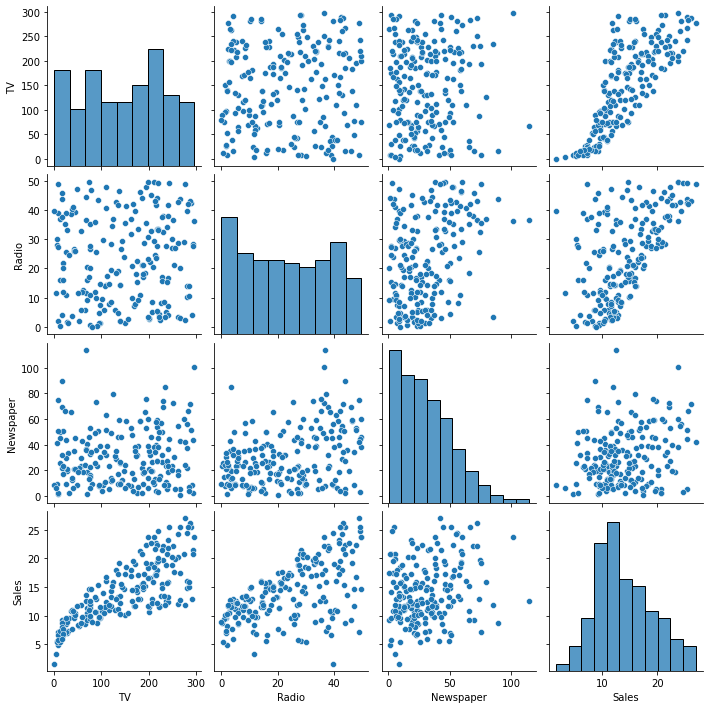

In [26]:
sns.pairplot(ads);

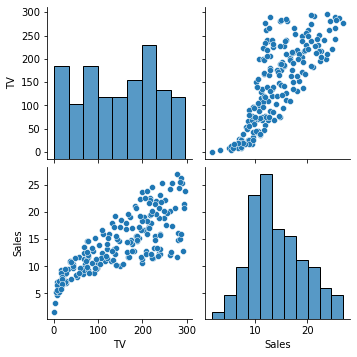

In [27]:
# Grab just TV and sales
sns.pairplot(ads[['TV', 'Sales']]);

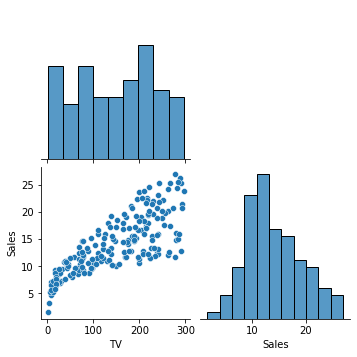

In [28]:
# Grab just TV and sales - and plot once!
sns.pairplot(ads[['TV', 'Sales']], corner=True);

<a id='x-y'></a>

## Create our features matrix (`X`) and target vector (`y`)
---

The following columns will be our features:
- `TV`
- `radio`
- `newspaper`

The `sales` column is our label: the column we're trying to predict.

In the cell below, create your `X` and `y` variables.

In [29]:
# Create a list of features
# use the list to create feature matrix (X)
# X = ads[['TV', 'radio', 'newspaper']] # another way to create X - uncomment to run
# Create y vector

In [31]:
features = ['TV', 'Radio', 'Newspaper'] # Create a list of features
X = ads[features] # use the list to create feature matrix (X)
# X = ads[['TV', 'radio', 'newspaper']] # another way to create X - uncomment to run
y = ads['Sales'] # Create y vector

<a name="train-test-split"></a>
## Train/Test Split and Model Validation

---

So far we've focused on fitting the best model to our data. But is this the best model for our sample data or the best model overall? How do we know?

In practice we need to validate our model's ability to generalize to new data. One popular method for performing model validation is by splitting our data into subsets: data on which we *train* our model and data on which we *test* our model.

The most basic type of "hold-out" validation is called **train/test split**. We split our data into two pieces:

> **"A Training Set":** The subset of the data on which we fit our model.

> **"A Testing Set":** The subset of the data on which we evaluate the quality of our predictions.


**Train/Test Split Benefits:**

- Testing data can represent "future" data; for prediction-oriented models, it's critical to ensure that a model that is performing well on current data will likely perform well on future data.
- It can help diagnose and avoid overfitting via model tuning.
- It can improve the quality of our predictions.

**Visual representation of Train-Test Split**:  
![](../assets/train-test-split.png)

<a id='sklearn-tts'></a>

## Scikit-Learn's `train_test_split` Function
---

Performing train/test splits using scikit-learn is easy — load the `train_test_split` function:

```python
from sklearn.model_selection import train_test_split
```

**Arguments**:
- *Arrays*: Any number of arrays/matrices to split up into training and testing sets (they should be the same length).
- `test_size`: An integer representing the exact size of the testing subset or a float for a percentage.
- `train_size`: Alternatively, you can specify the training size.
- `stratify`: Supply a vector to stratify the splitting (by more important classification tasks).
- `random_state`: a numerical seed for randomly splitting your data with reproducibility

**Perform a split of our `X` and `y`.**

In [50]:
train_test_split(X, y, random_state=42)

[        TV  Radio  Newspaper
 159  131.7   18.4       34.6
 100  222.4    4.3       49.8
 11   214.7   24.0        4.0
 187  191.1   28.7       18.2
 24    62.3   12.6       18.3
 ..     ...    ...        ...
 43   206.9    8.4       26.4
 22    13.2   15.9       49.6
 72    26.8   33.0       19.3
 15   195.4   47.7       52.9
 168  215.4   23.6       57.6
 
 [150 rows x 3 columns],
         TV  Radio  Newspaper
 112  175.7   15.4        2.4
 29    70.6   16.0       40.8
 182   56.2    5.7       29.7
 199  232.1    8.6        8.7
 193  166.8   42.0        3.6
 85   193.2   18.4       65.7
 10    66.1    5.8       24.2
 54   262.7   28.8       15.9
 115   75.1   35.0       52.7
 35   290.7    4.1        8.5
 12    23.8   35.1       65.9
 92   217.7   33.5       59.0
 13    97.5    7.6        7.2
 126    7.8   38.9       50.6
 174  222.4    3.4       13.1
 2     17.2   45.9       69.3
 44    25.1   25.7       43.3
 3    151.5   41.3       58.5
 113  209.6   20.6       10.7
 14   204.1  

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.head()

,TV,Radio,Newspaper
114,78.2,46.8,34.5
173,168.4,7.1,12.8
5,8.7,48.9,75.0
126,7.8,38.9,50.6
117,76.4,0.8,14.8


In [42]:
print(f"Shape of original data frame: {ads.shape}")
print(" ")
print(f"Shape of X train: {X_train.shape}")
print(f"Shape of y train: {y_train.shape}")
print(" ")
print(f"Shape of X test: {X_test.shape}")
print(f"Shape of y test: {y_test.shape}")

Shape of original data frame: (200, 4)
 
Shape of X train: (150, 3)
Shape of y train: (150,)
 
Shape of X test: (50, 3)
Shape of y test: (50,)


In [43]:
assert X_train.shape[0] == y_train.shape[0]

In [44]:
assert X_test.shape[0] == y_test.shape[0]

In [45]:
assert (X_train.shape[0] + X_test.shape[0]) == (y_train.shape[0] + y_test.shape[0])

# **MENTION THERE IS NO GOLDEN RULE ON WHAT KIND OF SPLIT**

## Linear Regression model
---

In the cells below:
1. create a `LinearRegression` model
2. fit it to your **training data** (`X_train`, `y_train`)

# **ONLY FIT THE TRAINING DATA**

In [46]:
lr = LinearRegression() # instantiate linear regression

In [47]:
lr.fit(X_train, y_train) # fit on training data ONLY

LinearRegression()

## Model Evaluation
---

We need two scores to determine if our model is performing well, or experiencing high bias/variance. Use the `.score()` method on **both** the training set (`X_train`, `y_train`) and the test set (`X_test`, `y_test`).

```python
model.score(X_train, y_train)
```

In [48]:
# Train score
lr.score(X_train, y_train)

0.8966445527601498

In [49]:
# Test score
lr.score(X_test, y_test)

0.8935163320163658

![](../assets/I-am-something-of.jpg)

In [63]:
# Vary Train Test Split by test_size
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=.3, random_state=2)
lr_2 = LinearRegression()
lr_2.fit(X_train, y_train)
print(f"Training R-squared score: {lr.score(X_train_2, y_train_2)}")
print(f"Testing R-squared score: {lr.score(X_test_2, y_test_2)}")

Training R-squared score: 0.9261543438457371
Testing R-squared score: 0.8214530009556478


In [64]:
# Training MSE
mean_squared_error(y_train_2, lr_2.predict(X_train_2))

2.0490739388365293

In [65]:
# Testing MSE
mean_squared_error(y_test_2, lr_2.predict(X_test_2))

4.538574946244025

In [66]:
# Training RMSE
print(mean_squared_error(y_train_2, lr_2.predict(X_train_2), squared=False))

# Testing RMSE
print(mean_squared_error(y_test_2, lr_2.predict(X_test_2), squared=False))

1.4314586752108946
2.1303931435873578


<a id='cross-val-k-fold'></a>

## K-Fold Cross-Validation

---

K-fold cross-validation takes the idea of a single train/test split and expands it to *multiple tests* across different train/test splits of your data.

For example, if you determine your training set will contain 80 percent of the data and your testing set will contain the other 20 percent, you could have five different 80/20 splits in which the test set in each is a different set of observations. We have:
- Five (K=5) training sets.
- Five (K=5) corresponding testing sets.

**K-fold cross-validation builds K models — one for each train/test pair — and evaluates those models on each respective test set.**

### K-Fold Cross-Validation Visually

<img src="https://snag.gy/o1lLcw.jpg?convert_to_webp=true" width="500">

---

Cross-validation helps us understand how a model parameterization may perform in a variety of cases. The k-fold cross-validation procedure can be described in pseudocode:

```
set k
create k groups of rows in data

for group i in k row groups:
    test data is data[group i]
    train data is data[all groups not i]
    
    fit model on train data
    
    score model on test data
    
evaluate mean of k model scores
evaluate variance of k model scores
```

Odd case No. 1:
> **When K=2**: This is equivalent to performing ***two*** mirror image 50-50 train/test splits.

Odd case No. 2:
> **When K=number of rows**: This is known as "leave-one-out cross-validation," or LOOCV. A model is built on all but one row and tested on the single excluded observation.

## K-Folds Cross Validation in `sklearn`
---

Now let's try out k-fold cross-validation. Again, scikit-learn provides useful functions to do the heavy lifting. 

The function `cross_val_score` returns the $R^2$ for each testing set. 

In the cells below, score your training set (`X_train`, `y_train`) using `cross_val_score`.


In [67]:
# instantiate a linear regression
model = LinearRegression()

# Use the model in cross_val_score
cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)

array([0.81922047, 0.92868213, 0.92647764, 0.91472696, 0.76837337])

# **LOTS OF VARIABILITY IN THE SCORES**

In [69]:
X_train.shape

(150, 3)

In [70]:
# What the model is scored on
150/5

30.0

# **COULD BE A LARGE OUTLIER IN THE DATA**

In [73]:
# instantiate a linear regression
model = LinearRegression()

# Use the model in cross_val_score
cross_val_score(estimator=model, X=X_train, y=y_train)

array([0.81922047, 0.92868213, 0.92647764, 0.91472696, 0.76837337])

In [74]:
# get the mean cross validated testing score
cross_val_score(estimator=model, X=X_train, y=y_train).mean()

0.8714961121899936

In [75]:
# get the standard deviation from cross validated testing score
cross_val_score(estimator=model, X=X_train, y=y_train).std()

0.065618834067393

In [76]:
# Running cross validation on the training subset
linreg = LinearRegression()
cross_val_score(estimator=linreg, X=X_train, y=y_train, cv=7) # cv changes the number of folds

array([0.7411309 , 0.93298134, 0.92025339, 0.9295643 , 0.86310594,
       0.94451992, 0.75681455])

![](../assets/Train-Test-Split-CV.png)

<a id='additional-resources'></a>

## Additional Resources

---

- [Cross-Validation Example](http://scikit-learn.org/stable/auto_examples/exercises/plot_cv_diabetes.html#example-exercises-plot-cv-diabetes-py).
- Review this [academic paper](http://frostiebek.free.fr/docs/Machine%20Learning/validation-1.pdf) on the underpinnings of the hold-out method, LOOCV, and k-folds.
- Review the scikit-learn [documentation](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) on cross-validation.
- Review this [Stanford lesson](https://www.youtube.com/watch?v=_2ij6eaaSl0) on cross-validation.
- Review this [blog post](http://www.win-vector.com/blog/2015/01/random-testtrain-split-is-not-always-enough/) on why TTS is not always sufficient.
- Review this Stack Exchange [discussion](http://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) on approximate TTS and validation set sizes.

---

Train-Test-split from scratch

In [57]:
import random

def split_data(data, prob):
    '''
    Split data into fractions [prob, 1-prob]
    '''
    data = data[:] #makes a shallow copy of your data
    random.shuffle(data) #shuffle modifies the list
    cut = int(len(data) * prob)
    return data[:cut], data[cut:]

In [58]:
data = [n for n in range(1000)]
train, test = split_data(data, 0.75)

assert len(train) == 750
assert len(test) == 250

In [59]:
assert sorted(train + test) == data

In [61]:
def tts(xs, ys, test_pct):
    idxs = [i for i in range(len(xs))]
    train_idxs, test_idxs = split_data(idxs, 1 - test_pct)
    
    return ([xs[i] for i in train_idxs], #x train
           [xs[i] for i in test_idxs], # x_test
           [ys[i] for i in train_idxs], # y_train
           [ys[i] for i in test_idxs]) #y_test)

In [62]:
xs = [x for x in range(1000)]
ys = [2 * x for x in xs]

x_train, x_test, y_train, y_test = tts(xs, ys, 0.25)

In [63]:
assert len(x_train) == len(y_train) == 750
assert len(x_test) == len(y_test) == 250

In [64]:
#Check all corresponding data points are paired correctly

assert all(y == 2 * x for x, y in zip(x_train, y_train))
assert all(y == 2 * x for x, y in zip(x_test, y_test))

### Another Example from:

https://git.generalassemb.ly/dsir-426/dsir-426-instructor/blob/master/week-03/3.02-lesson-train-test-split-cross-validation/solution-code/train-test-split-cheatsheet.py

        age       sex       bmi       map        tc       ldl       hdl  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005671 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

        tch       ltg       glu  
0 -0.002592  0.019908 -0.017646  
1 -0.039493 -0.068330 -0.092204  
2 -0.002592  0.002864 -0.025930  
3  0.034309  0.022692 -0.009362  
4 -0.002592 -0.031991 -0.046641  
(442, 10)
(442,)
(353, 10) (353,)
(89, 10) (89,)
Score: 0.4303399936099509
Cross-validated scores: [0.4554861  0.46138572 0.40094084 0.55220736 0.43942775 0.56923406]
Cross-Predicted Accuracy: 0.4908065838640774


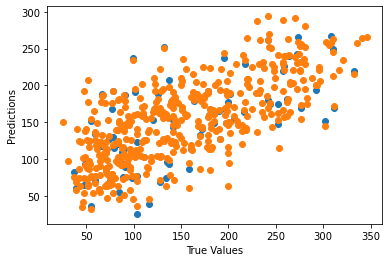

In [56]:
%matplotlib inline

from matplotlib import pyplot as plt
# Make the plots bigger
#plt.rcParams['figure.figsize'] = 10, 10

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split

# Load the Diabetes dataset
columns = "age sex bmi map tc ldl hdl tch ltg glu".split()
diabetes = datasets.load_diabetes()
df = pd.DataFrame(diabetes.data, columns=columns)
y = diabetes.target
# Take a look at the data again
print(df.head())
print(df.shape)
print(y.shape)

assert df.shape[0] == y.shape[0]

'''
Scikit-learn has a nice function to split a dataset for testing and training called train_test_split. The test_size keyword argument indicates the proportion of the data that should be held over for testing.
'''

# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


# fit a model
lm = linear_model.LinearRegression()

model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

## The line / model
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print("Score:", model.score(X_test, y_test))

'''
Now let's try out k-fold cross-validation. Again scikit-learn provides useful functions to do the heavy lifting. The function cross_val_predict returns the predicted values for each data point when it's in the testing slice.
'''
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn import metrics


# Perform 6-fold cross validation
scores = cross_val_score(model, df, y, cv=6)
print("Cross-validated scores:", scores)
# Make cross validated predictions
predictions = cross_val_predict(model, df, y, cv=6)
plt.scatter(y, predictions)
accuracy = metrics.r2_score(y, predictions)
print("Cross-Predicted Accuracy:", accuracy)